# Snippets

In [4]:
import numpy as np
from scipy.linalg import eig, eigh
import pandas as pd
from matplotlib.pyplot import plot, scatter
import seaborn as sns
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

In [5]:
# Generate Gaussian clusters
n = 10
d = 3
c = 2
X, y = make_blobs(n_samples=n, n_features=d, centers=c, random_state=1)
df = pd.DataFrame(X, columns=[f'x{x}' for x in range(d)])
X_df = df.copy()
Xy_df = df.copy()
Xy_df['y'] = y
Xy_df

,x0,x1,x2,y
0,-3.422993,-7.756543,-8.549982,1
1,-4.076239,-8.000652,-8.421116,1
2,-3.961099,6.151302,-10.758919,0
3,-0.525790,3.306599,-10.170141,0
4,-1.340521,4.157119,-8.535605,0
5,-3.450854,-6.164026,-8.836956,1
6,-2.187732,3.333521,-9.132305,0
7,-5.053968,-5.920158,-7.251637,1
8,-3.719701,4.084073,-10.381767,0
9,-4.831207,-7.022668,-7.570413,1


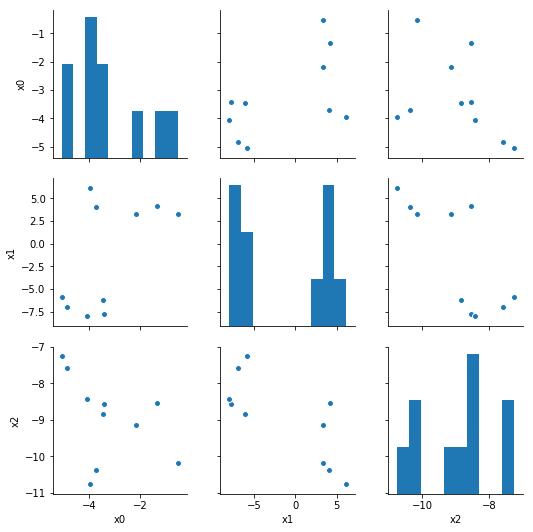

In [6]:
sns.pairplot(X_df);

In [7]:
Sigma_C = np.cov(X, rowvar=False, ddof=0)
Sigma_C

array([[  1.94290854,   4.50718734,  -0.65423316],
       [  4.50718734,  32.12506576,  -4.78186721],
       [ -0.65423316,  -4.78186721,   1.2254871 ]])

In [8]:
((X-X.mean(axis=0)).T @ (X-X.mean(axis=0))) / n

array([[  1.94290854,   4.50718734,  -0.65423316],
       [  4.50718734,  32.12506576,  -4.78186721],
       [ -0.65423316,  -4.78186721,   1.2254871 ]])

In [9]:
E_C, V_C = eig(Sigma_C)
Sigma_recon = V_C @ np.diag(E_C) @ V_C.T
Sigma_recon - Sigma_C

array([[  4.66293670e-15+0.j,   1.86517468e-14+0.j,  -2.88657986e-15+0.j],
       [  1.86517468e-14+0.j,   2.13162821e-14+0.j,  -4.44089210e-15+0.j],
       [ -2.88657986e-15+0.j,  -3.55271368e-15+0.j,   6.66133815e-16+0.j]])

In [10]:
E_Ch, V_Ch = eigh(Sigma_C)
Sigma_reconh = V_Ch @ np.diag(E_Ch) @ V_Ch.T
Sigma_reconh - Sigma_C

array([[  0.00000000e+00,   3.55271368e-15,  -5.55111512e-16],
       [  3.55271368e-15,   7.10542736e-15,   0.00000000e+00],
       [ -6.66133815e-16,   0.00000000e+00,   2.22044605e-16]])

## kNN

In [11]:
from sklearn.neighbors import NearestNeighbors

In [12]:
k = 5
N_JOBS = 4
nn = NearestNeighbors(n_neighbors=k, metric='minkowski', n_jobs=N_JOBS)

In [13]:
nn.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=4, n_neighbors=5, p=2, radius=1.0)

In [18]:
dist, knns = nn.kneighbors()

In [19]:
knns

array([[1, 5, 9, 7, 6],
       [0, 9, 5, 7, 6],
       [8, 6, 4, 3, 5],
       [6, 4, 8, 2, 5],
       [6, 3, 8, 2, 5],
       [0, 1, 9, 7, 6],
       [4, 3, 8, 2, 5],
       [9, 5, 1, 0, 6],
       [6, 2, 4, 3, 5],
       [7, 1, 0, 5, 6]])

In [21]:
for knn in knns:
    X_knn = X[knn]

In [22]:
X_knn

array([[-5.05396772, -5.92015847, -7.25163738],
       [-4.07623877, -8.00065162, -8.42111618],
       [-3.42299308, -7.75654294, -8.54998163],
       [-3.45085421, -6.16402623, -8.83695596],
       [-2.18773166,  3.33352125, -9.13230487]])

In [23]:
X.shape

(10, 3)

In [28]:
X[:, ...]

array([[ -3.42299308,  -7.75654294,  -8.54998163],
       [ -4.07623877,  -8.00065162,  -8.42111618],
       [ -3.9610986 ,   6.15130163, -10.7589194 ],
       [ -0.52579046,   3.3065986 , -10.17014071],
       [ -1.34052081,   4.15711949,  -8.53560457],
       [ -3.45085421,  -6.16402623,  -8.83695596],
       [ -2.18773166,   3.33352125,  -9.13230487],
       [ -5.05396772,  -5.92015847,  -7.25163738],
       [ -3.71970062,   4.08407266, -10.38176686],
       [ -4.83120697,  -7.02266844,  -7.57041289]])

In [ ]:
E_Ch, V_Ch = eigh(Sigma_C)

In [29]:
E_Ch

array([  0.50147794,   1.28664582,  33.50533763])

In [63]:
e_hat = (np.arange(d) > lambda_P).astype(int)

In [64]:
e_hat

array([0, 0, 1])

In [38]:
E_Ch = np.sort(E_Ch)[::-1]
expl = np.cumsum(E_Ch) / np.sum(E_Ch)
expl

array([ 0.94933555,  0.98579119,  1.        ])

In [42]:
lambda_P = np.searchsorted(expl, 0.95, side='left')
lambda_P

1

In [43]:
np.digitize([0,1,1,2,1,0,0,1,2,2], np.arange(d), )

array([1, 2, 2, 3, 2, 1, 1, 2, 3, 3])

In [49]:
tmp = np.array([0,1,1,2,1,0,0,1,2,2])

In [50]:
argsorted = np.argsort(tmp)
argsorted

array([0, 5, 6, 1, 2, 4, 7, 3, 8, 9])

In [52]:
tmp[argsorted]

array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2])

In [57]:
edges, _ = np.histogram(tmp[argsorted], bins=np.arange(3))
edges

array([3, 7])

In [59]:
D = np.split(argsorted, edges)

In [67]:
D

[array([0, 5, 6]), array([1, 2, 4, 7]), array([3, 8, 9])]

In [60]:
D[0]

array([0, 5, 6])

In [66]:
np.max([0, 5])

5